In [1]:
%load_ext autoreload
%autoreload 2

# Unbiased ECMWF

Here we propose a small model which is a debiased ECMWF forecast according to the data we have.
Compute and score the climatology, to use as a baseline.

In [188]:
import dask
import dask.array as da
import dask.distributed
import dask_jobqueue
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import scipy.stats
import xarray as xr

In [51]:
from crims2s.util import fix_dataset_dims

In [6]:
INPUT_TRAIN = '***BASEDIR***training-input/0.3.0/netcdf'
OBSERVATIONS = '***BASEDIR***training-output-reference/'

## Boost dask cluster

In [7]:
cluster = dask_jobqueue.SLURMCluster(
    env_extra=['source ***HOME***.bash_profile','conda activate s2s'],
)

In [8]:
cluster.scale(jobs=3)  # Scale to two working nodes as configured.
client = dask.distributed.Client(cluster)

In [9]:
client

Client Scheduler: tcp://10.20.40.96:41649 Dashboard: http://10.20.40.96:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Open model data

In [26]:
CENTER = 'ecmwf'
FIELD = 't2m'

In [27]:
input_path = pathlib.Path(INPUT_TRAIN)

In [28]:
files = sorted([f for f in input_path.iterdir() if CENTER in f.stem and FIELD in f.stem])

In [29]:
files[:10]

[PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200102.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200109.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200116.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200123.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200130.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200206.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200213.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200220.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200227.nc'),
 PosixPath('***BASEDIR***training-input/0.3.0/netcdf/ecmwf-hindcast-t2m-20200305.nc')]

In [139]:
one_ecmwf = xr.open_dataset(files[0])

In [138]:
one_ecmwf.forecast_time[0].dt.isocalendar().week.item()

52

In [140]:
ecmwf = xr.open_mfdataset(files, preprocess=fix_dataset_dims)

In [141]:
ecmwf

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 20, latitude: 121, lead_time: 46, longitude: 240, realization: 11)
Coordinates:
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 20, 46), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, realization, lead_time, latitude, longitude) float32 dask.array<chunksize=(20, 1, 11, 46, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-10T16:32 GRIB to CDM+CF via cfgrib-0.9.9...

In [146]:
ecmwf_train = ecmwf.sel(forecast_year=slice(None, 2018))
ecmwf_val = ecmwf.sel(forecast_year=slice(2019, None))

In [147]:
ecmwf_train

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 19, latitude: 121, lead_time: 46, longitude: 240, realization: 11)
Coordinates:
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 19, 46), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2016 2017 2018
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, realization, lead_time, latitude, longitude) float32 dask.array<chunksize=(19, 1, 11, 46, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-10T16:32 GRIB to CDM+CF via cfgrib-0.9.9...

In [148]:
ecmwf_val

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 46, longitude: 240, realization: 11)
Coordinates:
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 1, 46), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, realization, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 1, 11, 46, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-10T16:32 GRIB to CDM+CF via cfgrib-0.9.9...

In [57]:
ecmwf_mean = ecmwf.mean(dim='realization')
ecmwf_std = ecmwf.std(dim='realization')

In [58]:
ecmwf_mean

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 20, latitude: 121, lead_time: 46, longitude: 240)
Coordinates:
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 20, 46), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(20, 1, 46, 121, 240), meta=np.ndarray>

## Open observations

In [10]:
obs_path = pathlib.Path(OBSERVATIONS)
obs_files = [f for f in obs_path.iterdir() if 't2m' in f.stem]

In [72]:
obs = xr.open_mfdataset(obs_files, preprocess=fix_dataset_dims).isel(lead_time=slice(1, None))

In [73]:
obs

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 20, latitude: 121, lead_time: 46, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 20, 46), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(20, 1, 46, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [149]:
obs_train = obs.sel(forecast_year=slice(None, 2018))
obs_val = obs.sel(forecast_year=slice(2019, None))

In [150]:
obs_train

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 19, latitude: 121, lead_time: 46, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 19, 46), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2016 2017 2018
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(19, 1, 46, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [20]:
climatology_mean = obs_weeks34.mean(dim=['forecast_year', 'lead_time']).compute()

In [21]:
climatology_std = obs_weeks34.std(dim=['forecast_year', 'lead_time']).compute()

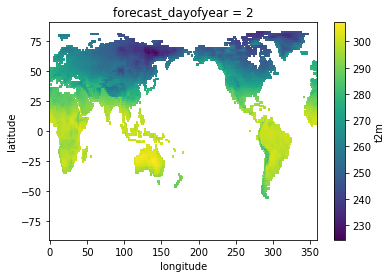

In [24]:
climatology_mean.isel(forecast_dayofyear=0).t2m.plot()

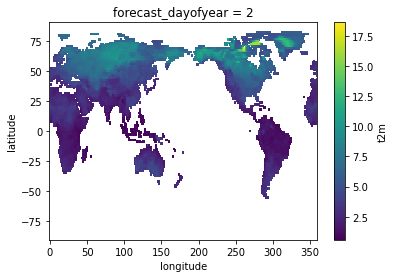

In [25]:
climatology_std.isel(forecast_dayofyear=0).t2m.plot()

## Compute model bias

In [113]:
ecmwf_train_mean = ecmwf_train.mean(dim='realization')

In [114]:
ecmwf_train_bias = ecmwf_train_mean - obs_train

In [115]:
ecmwf_train_bias_week34 = ecmwf_train_bias.sel(lead_time=slice(datetime.timedelta(days=14), datetime.timedelta(days=28))).mean(dim=['forecast_year', 'lead_time'])

In [116]:
ecmwf_train_bias_week34

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, latitude: 121, longitude: 240)
Coordinates:
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
Data variables:
    t2m                 (forecast_dayofyear, latitude, longitude) float32 dask.array<chunksize=(1, 121, 240), meta=np.ndarray>

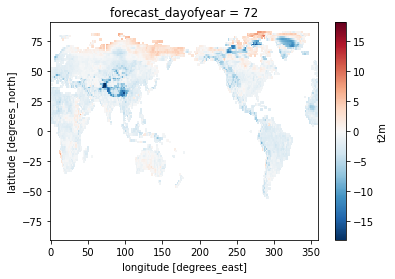

In [118]:
ecmwf_train_bias_week34.isel(forecast_dayofyear=10).t2m.plot()

In [153]:
ecmwf_val_w34 = ecmwf_val.sel(lead_time=slice('14D', '28D'))

In [120]:
ecmwf_val_w34_debiased = ecmwf_val_w34 - ecmwf_train_bias_week34

In [127]:
ecmwf_val_w34_debiased_mean = ecmwf_val_w34_debiased.mean(dim=['realization', 'lead_time'])

In [143]:
ecmwf_val_w34_debiased_mean

,Array,Chunk
Bytes,5.87 MiB,113.44 kiB
Shape,"(1, 53, 121, 240)","(1, 1, 121, 240)"
Count,1272 Tasks,53 Chunks
Type,float32,numpy.ndarray


In [170]:
ecmwf_val_w34_debiased_std = ecmwf_val_w34_debiased.std(dim=['realization', 'lead_time'])

In [171]:
ecmwf_val_w34_debiased_std

,Array,Chunk
Bytes,5.87 MiB,113.44 kiB
Shape,"(1, 53, 121, 240)","(1, 1, 121, 240)"
Count,1325 Tasks,53 Chunks
Type,float32,numpy.ndarray


In [144]:
obs_train

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 20, latitude: 121, lead_time: 46, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 20, 46), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(20, 1, 46, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [142]:
obs_val - ecmwf_val_w34_debiased_mean

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 46, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 1, 46), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 1 days 2 days ... 46 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 1, 46, 121, 240), meta=np.ndarray>

In [151]:
obs_val_w34 = obs_val.sel(lead_time=slice('14D', '27D'))

In [152]:
obs_val_w34

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 53, forecast_year: 1, latitude: 121, lead_time: 14, longitude: 240)
Coordinates:
    valid_time          (forecast_dayofyear, forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(1, 1, 14), meta=np.ndarray>
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * lead_time           (lead_time) timedelta64[ns] 14 days 15 days ... 27 days
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2019
Data variables:
    t2m                 (forecast_year, forecast_dayofyear, lead_time, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 121, 240), meta=np.ndarray>
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [162]:
obs_train_w34 = obs_train.sel(lead_time=slice('14D', '27D'))

In [164]:
thresholds = obs_train_w34.quantile([.33, .66], dim=['forecast_year', 'lead_time'])

In [166]:
thresholds

,Array,Chunk
Bytes,23.49 MiB,453.75 kiB
Shape,"(2, 53, 121, 240)","(2, 1, 121, 240)"
Count,689 Tasks,53 Chunks
Type,float64,numpy.ndarray


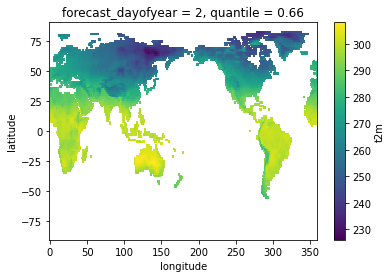

In [169]:
thresholds.isel(quantile=1, forecast_dayofyear=0).t2m.plot()

In [ ]:
ecmwf_val_w34_debiased_mean
ecmwf_val_w34_debiased_std

In [178]:
forecast_distribution = scipy.stats.norm(loc=ecmwf_val_w34_debiased_mean.t2m.data, scale=ecmwf_val_w34_debiased_std.t2m.data)

In [179]:
p_below = forecast_distribution.cdf(thresholds.isel(quantile=0).t2m.data)

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [180]:
p_below = _

In [183]:
p_below.isnan()

AttributeError: 'numpy.ndarray' object has no attribute 'isnan'

In [186]:
np.isnan(p_below).sum()

1163668

In [187]:
p_below.shape

(1, 53, 121, 240)

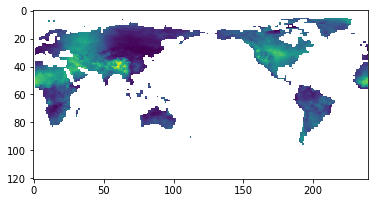

In [196]:
plt.imshow(p_below[0,6])

In [208]:
p_above = forecast_distribution.cdf(thresholds.isel(quantile=1).t2m.data)

In [209]:
p_normal = p_above - p_below

In [210]:
p_normal.shape

(1, 53, 121, 240)

In [211]:
p_above = np.ones_like(p_above) - p_above

In [212]:
(p_above + p_normal + p_below)[0, 0][~np.isnan(p_above)[0, 0]].mean()

1.0

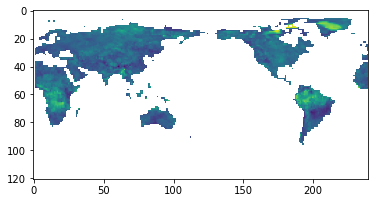

In [213]:
fig, ax = plt.subplots()
ax.imshow(p_normal[0, 0])

In [225]:
forecast = np.stack([p_below, p_normal, p_above])

In [226]:
forecast.shape

(3, 1, 53, 121, 240)

In [227]:
forecast = xr.DataArray(forecast, dims=['category', 'forecast_year', 'forecast_dayofyear', 'latitude', 'longitude'], coords={
    'category': xr.DataArray(['below normal', 'within normal', 'above normal'], dims='category'),
})

In [228]:
obs_train_w34.forecast_time

<xarray.DataArray 'forecast_time' (forecast_dayofyear: 53, forecast_year: 19)>
array([['2000-01-02T00:00:00.000000000', '2001-01-02T00:00:00.000000000',
        '2002-01-02T00:00:00.000000000', ...,
        '2016-01-02T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
        '2018-01-02T00:00:00.000000000'],
       ['2000-01-09T00:00:00.000000000', '2001-01-09T00:00:00.000000000',
        '2002-01-09T00:00:00.000000000', ...,
        '2016-01-09T00:00:00.000000000', '2017-01-09T00:00:00.000000000',
        '2018-01-09T00:00:00.000000000'],
       ['2000-01-16T00:00:00.000000000', '2001-01-16T00:00:00.000000000',
        '2002-01-16T00:00:00.000000000', ...,
        '2016-01-16T00:00:00.000000000', '2017-01-16T00:00:00.000000000',
        '2018-01-16T00:00:00.000000000'],
       ...,
       ['2000-12-17T00:00:00.000000000', '2001-12-17T00:00:00.000000000',
        '2002-12-17T00:00:00.000000000', ...,
        '2016-12-17T00:00:00.000000000', '2017-12-17T00:00:00.000000000',
        '2018-12-17T00:00:00.000000000'],
       ['2000-12-24T00:00:00.000000000', '2001-12-24T00:00:00.000000000',
        '2002-12-24T00:00:00.000000000', ...,
        '2016-12-24T00:00:00.000000000', '2017-12-24T00:00:00.000000000',
        '2018-12-24T00:00:00.000000000'],
       ['2000-12-31T00:00:00.000000000', '2001-12-31T00:00:00.000000000',
        '2002-12-31T00:00:00.000000000', ...,
        '2016-12-31T00:00:00.000000000', '2017-12-31T00:00:00.000000000',
        '2018-12-31T00:00:00.000000000']], dtype='datetime64[ns]')
Coordinates:
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2016 2017 2018
Attributes:
    standard_name:  forecast_reference_time
    long_name:      initial time of forecast

In [230]:
forecast = forecast.assign_coords({
    'forecast_dayofyear': obs_train_w34.forecast_dayofyear,
    'latitude': obs_train_w34.latitude,
    'longitude': obs_train_w34.longitude,
    'forecast_time': obs_val_w34.forecast_time
})

In [231]:
forecast

<xarray.DataArray (category: 3, forecast_year: 1, forecast_dayofyear: 53, latitude: 121, longitude: 240)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * category            (category) <U13 'below normal' ... 'above normal'
  * forecast_dayofyear  (forecast_dayofyear) int64 2 9 16 23 ... 345 352 359 366
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * forecast_year       (forecast_year) int64 2019
    forecast_time       (forecast_dayofyear, forecast_year) datetime64[ns] 20...

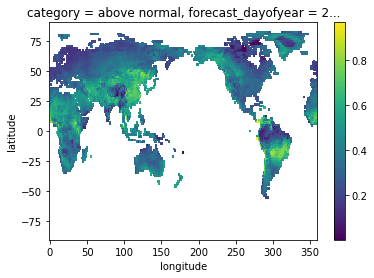

In [236]:
forecast.isel(forecast_dayofyear=0).isel(category=2).plot()